# Classes of cities -- clustering analysis

This notebook presents an analysis of cities using remote-sensing data on macro-level socio-demographic indicators. In particular, we characterize cities by the dependence with distance (from the city center) of several macroeconomic quantities:
* built areas $x_{bldg}(d)$ estimated from SAR/GUF data
* population density $x_{pop}(d)$ estimated from LandScan data
* luminosity $x_{lum}(d)$ estimated from VIIRS (nightlights) data.

We model each quantity (population, luminosity, built area) by breaking it down into a scale component and a spatial profile component:

<p><center> $\displaystyle x(d) = c \cdot \hat{x}(d)$ </center></p>

We analyze cities from the perspective of patterns in each of the components $c$ and $\hat{x}(\cdot)$. We'll have one such set of objects for each data source we consider (population, luminosity, building density).

We expect (as shown empirically below) that the distribution of the scale factor $c$ across cities is heavily skewed towards small $c$, and is approximately a log-normal. 

At the same time, prior research on urban form typically models the relationship of $x (d)$ with distance $d$ using an exponential form:

<p><center> $\displaystyle x(d) = x_0 e^{-\gamma d}$ </center></p>

Above, $\gamma$ is the _average (radial) spatial gradient_ which previous studies (e.g., Alain Bertaud's work) have investigated. This can be estimated readily via linear regression:

<p><center> $\displaystyle \text{log } x(d) = \text{log } x_0 -\gamma d$ </center></p>

(Note we will use 10-base logarithm, but still refer to it as _log_ for ease of notation.)

The two expressions for $x(d)$ are equivalent, so $c$ could be identified as $\text{log }x_0$, but we'll prefer to retain the scale factor $c$, because it has a more direct interpretation. 





# Packages

In [478]:
import numpy as np
import pandas as pd

import geopandas as gpd
import shapely.wkt
from shapely import geometry
import geojson
from shapely.geometry import shape
from shapely.wkt import loads

import re

import sys, os, time
import glob

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle
import copy

colormap = {"bldg":"black", "pop":"green", "lum":"orange", "all":"blue"}

cmap_bld = sns.light_palette("black", n_colors=10)
cmap_pop = sns.light_palette("green", n_colors=10)
cmap_lum = sns.light_palette("orange",n_colors=10)


cmap_dict = {"bldg":ListedColormap(cmap_bld), 
             "pop":ListedColormap(cmap_pop), 
             "lum":ListedColormap(cmap_lum)}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


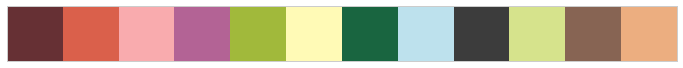

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib

# define a custom color palette
my_colors = [
 (102, 48, 52),
 (218, 96, 75),
 (249, 171, 174),
 (179, 99, 149),
 # (215, 187, 208),
 # (218, 198, 199),
 (161, 185, 59),
 # (214, 227, 140),
 (255, 250, 182),
 (25, 101, 64),
 (189, 225, 237),
 (60, 60, 60),
 (214, 227, 140),
 (135, 100, 83),
 (236, 174, 128)]

my_colors = [(np.array(v)/float(255)).tolist() + [1.0] for v in my_colors]

my_cmap = matplotlib.colors.ListedColormap(my_colors)

sns.palplot(sns.color_palette(my_colors))

# Load city feature data for analysis

In [3]:
dataroot = "/home/data/world-cities/"

#### Data on raw variable profiles with distance

In [4]:
# load pre-computed profile data

with gzip.open(dataroot + "spatial-maps/stats_cities_over10kpop.pickle.gz", "r") as f:
    cities = pickle.load(f)
print len(cities)  

# load pruned list of cities
cities_sel_df = pd.read_csv(dataroot + "/selected_urban_areas_100k.csv").drop("index",axis=1)

parse_location = lambda s: shape(loads(s))
cities_sel_df['location'] = cities_sel_df['location'].apply(parse_location)

def include(v):
    return ((cities_sel_df.city.str.contains(v['city'])) & \
           (cities_sel_df.population==v['population']) & \
           (cities_sel_df.country.str.contains(v['country']))).sum()>0 
 
cities_sel = {k:v for k,v in cities.iteritems() if include(v)}
print len(cities_sel)

L = len(cities.values()[0]['profiles']['bldg'][0]) # length of profile in km
distance_km = np.arange(L)

29850


# Analyze city scale

#### Format scale data

In [55]:
scales_within = np.vstack([
                    [v['avg area bnds']['bldg'] for k,v in cities_sel.iteritems()],
                    [v['population'] for k,v in cities_sel.iteritems()],
                    [v['avg area bnds']['lum'] for k,v in cities_sel.iteritems()]
]).T

scales_total = np.vstack([
                    [v['avg area']['bldg'] for k,v in cities_sel.iteritems()],
                    [v['sum area']['pop'] for k,v in cities_sel.iteritems()],
                    [v['avg area']['lum'] for k,v in cities_sel.iteritems()]
 ]).T

scales_max = np.vstack([
                    [v['profiles']['bldg'][0].max() for k,v in cities_sel.iteritems()],
                    [v['profiles']['pop'][0].max() for k,v in cities_sel.iteritems()],
                    [v['profiles']['lum'][0].max() for k,v in cities_sel.iteritems()]   
]).T

scales = np.hstack([scales_within, scales_total, scales_max])
columns_scales = ["bldg-in", "pop-in", "lum-in", 
                  "bldg-tot", "pop-tot", "lum-tot",
                  "bldg-max", "pop-max", "lum-max"]
scales_df = pd.DataFrame(scales, columns=columns_scales)
scales_df.fillna(0, inplace=True)

info_df = pd.DataFrame(np.array(
                        [[v['city'] for k,v in cities_sel.iteritems()],
                        [v['size'] for k,v in cities_sel.iteritems()],
                        [v['subregion'] for k,v in cities_sel.iteritems()],
                        [v['region'] for k,v in cities_sel.iteritems()]]).T,
                      columns=['city', 'scale-pop', 'subregion', 'region'])
scales_df = pd.concat([info_df, scales_df], axis=1)

scales_df.head()

,city,scale-pop,subregion,region,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max
0,pcs,small-1,Eastern Europe,Europe,0.079496,179109.0,1.255444,0.033861,7.258769e+05,0.337202,0.642461,2095.800000,18.472693
1,goyang,large,Eastern Asia,Asia,0.349494,1033714.0,21.358686,0.195003,2.231682e+07,11.698015,0.663632,12563.666667,31.203003
2,mazowe,small-1,Eastern Africa,Africa,0.002294,161956.0,0.023511,0.003470,5.314265e+05,0.034665,0.030290,64.934282,0.155501
3,ihorombe,small-1,Eastern Africa,Africa,0.000716,135148.0,0.000587,0.000627,1.002725e+05,0.000502,0.057143,153.371429,0.124188
4,magelang,large,South-Eastern Asia,Asia,0.114572,1494199.0,0.547013,0.125196,1.009845e+07,0.868255,0.590235,3859.000000,6.042631


Let's standardize the profiles by subtracting the mean and scaling by variance. This is to compare relative variation across cities between population, luminosity, and buildings.

In [35]:
from sklearn.preprocessing import StandardScaler

scales_std = StandardScaler().fit_transform(scales)
scales_std_df = pd.DataFrame(scales_std, columns=columns_scales)
scales_std_df = pd.concat([info_df, scales_std_df], axis=1)

#### Create scale-based classifications for bld and lum

For population we have a standard classification system (5 classes of cities by population). Let's create a simple classification for built density and for luminosity.

For each dimension (lum, bld) we can try different statistics to classify by
* average within bounds
* average total (including city + 50km area around city center)
* maximum density

In [56]:
scales_df['scale-pop'].value_counts()

small-1       1443
small-2       1440
large          915
medium         626
very-large     135
Name: scale-pop, dtype: int64

In [85]:
typ = "in"
classes = ['low', 'med', 'hi']

q_bld = np.percentile(scales_df['bldg-%s'%typ].dropna(), (0,25, 75,100))
scales_df['scale-bldg'] = ''
for p in range(3):
    idx = (scales_df['bldg-%s'%typ]>=q_bld[p]) & (scales_df['bldg-%s'%typ]<=q_bld[p+1])
    scales_df.ix[idx,'scale-bldg'] = classes[p]

q_lum = np.percentile(scales_df['lum-%s'%typ].dropna(), (0,25, 75,100))
scales_df['scale-lum'] = ''
for p in range(3):
    idx = (scales_df['lum-%s'%typ]>=q_lum[p]) & (scales_df['lum-%s'%typ]<=q_lum[p+1])
    scales_df.ix[idx,'scale-lum'] = classes[p]


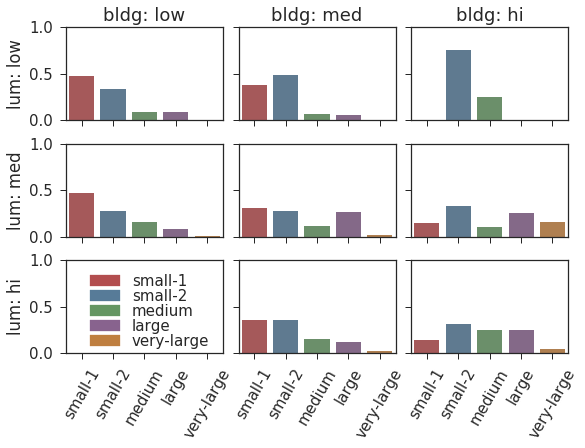

In [316]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(3,3, figsize=(9,6),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=True, sharey=True)
pop_scales = ["small-1", "small-2", "medium", "large", "very-large"]
pop_colors = sns.color_palette("Set1", n_colors=len(pop_scales), desat=.5)
for i,l in enumerate(["low", "med", "hi"]):
    for j,b in enumerate(["low", "med", "hi"]):
        a = ax[i,j]
        cur_df = scales_df[(scales_df['scale-lum']==l) & (scales_df['scale-bldg']==b)]
        a.set_xlabel(''); a.set_ylabel('')
        a.set_xticklabels(g.get_xticklabels(), rotation=60)
        a.set_ylim([0, 1])

        if i==0:
            a.set_title("bldg: %s"%b)
        if j==0:
            a.set_ylabel("lum: %s"%l)
        if len(cur_df) < 3:
            continue
#         pcts = cur_df.groupby("scale-pop").apply(lambda x: x['region'].value_counts()/float(len(x)))
#         pcts = pd.DataFrame(pcts).reset_index()
#         pcts.columns = ["scale-pop", "region", "pct"]
#         g = sns.barplot(x="region", y="pct", hue="scale-pop", 
#                         data=pcts, ax=a)
        pcts = cur_df['scale-pop'].value_counts() / float(len(cur_df))
        g = sns.barplot(pcts.index, pcts.values, order=pop_scales, ax=a,
                       palette=pop_colors)
        # a.legend_.remove() #, bbox_to_anchor=(1.1, 1.05))
  
# fig.delaxes(ax[2,0])
# ax[2,0].set_xticks([]); ax[2,0].set_yticks([])

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

legend_patches = [mpatches.Patch(color=c, label=l) \
                  for l,c in zip(pop_scales, pop_colors)]

plt.legend(handles=legend_patches, bbox_to_anchor=(-1.2, 1.), 
           ncol=1, labelspacing=0. )



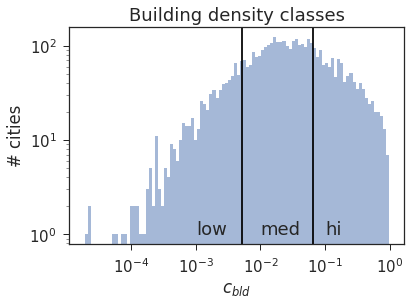

In [257]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots()
scales_df['bldg-in'].apply(lambda x: np.log10(x) if x>0 else np.nan).hist(bins=100, log=True, figsize=(6,4), alpha=0.5, ax=ax)
for q in q_bld[1:-1]:
    ax.axvline(x=np.log10(q), color=colormap["bldg"])
ax.set_title("Building density classes")
ax.set_xlabel("$c_{bld}$")
ax.set_ylabel("# cities")
ax.grid(False)
fig.canvas.draw()
new_labels = ["$10^{%s}$"%x.get_text() for x in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
ax.annotate("low", xy=(-3,1))
ax.annotate("med", xy=(-2,1))
ax.annotate("hi", xy=(-1,1))

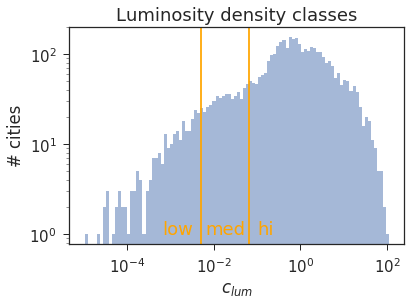

In [258]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots()
scales_df['lum-in'].apply(lambda x: np.log10(x) if x>0 else np.nan).hist(bins=100, log=True, figsize=(6,4), alpha=0.5, ax=ax)
for q in q_bld[1:-1]:
    ax.axvline(x=np.log10(q), color=colormap["lum"])
ax.set_title("Luminosity density classes")
ax.set_xlabel("$c_{lum}$")
ax.set_ylabel("# cities")
ax.grid(False)
fig.canvas.draw()
new_labels = ["$10^{%s}$"%x.get_text() for x in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
ax.annotate("low", xy=(-3.2,1), color=colormap["lum"])
ax.annotate("med", xy=(-2.2,1), color=colormap["lum"])
ax.annotate("hi", xy=(-1,1), color=colormap["lum"])

Let's segment the built-area normalized city scales into _low_, _medium_, and _high_ categories by the percentiles of the marginal distributions for population and density.

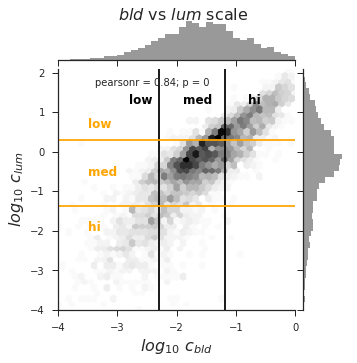

In [308]:
sns.set_context("notebook", font_scale=1.5)
sns.set(style="ticks")

idx_ok = (scales_df['bldg-in']>0) & (scales_df['lum-in']>0)

g = sns.jointplot(np.log10(scales_df['bldg-in'][idx_ok]), 
                  np.log10(scales_df['lum-in'][idx_ok]), 
                  kind="hex", color="black", size=5, xlim=(-4,0), ylim=(-4,2.1))
g.fig.suptitle("$bld$ vs $lum$ scale", fontsize=16)
g.ax_joint.set_xlabel("$log_{10} \ c_{bld}$", fontsize=16)
g.ax_joint.set_ylabel("$log_{10} \ c_{lum}$", fontsize=16)

for q in q_bld[1:-1]:
    g.ax_joint.axvline(x=np.log10(q), color=colormap["bldg"])
    
for q in q_lum[1:-1]:
    g.ax_joint.axhline(y=np.log10(q), color=colormap["lum"])
    
for qp,sp in zip([-2.8,-1.9, -0.8], ["low", "med", "hi"]):
    g.ax_joint.annotate(sp, xy=(qp, 1.2), color=colormap["bldg"], weight='bold')   
for qp,sp in zip([0.6, -0.6, -2], ["low", "med", "hi"]):
    g.ax_joint.annotate(sp, xy=(-3.5, qp), color=colormap["lum"], weight='bold')           

In [321]:
scales_df.head()

,city,scale-pop,subregion,region,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max,scale-bld,scale-lum,scale-bldg
0,pcs,small-1,Eastern Europe,Europe,0.079496,179109.0,1.255444,0.033861,7.258769e+05,0.337202,0.642461,2095.800000,18.472693,med,med,hi
1,goyang,large,Eastern Asia,Asia,0.349494,1033714.0,21.358686,0.195003,2.231682e+07,11.698015,0.663632,12563.666667,31.203003,med,hi,hi
2,mazowe,small-1,Eastern Africa,Africa,0.002294,161956.0,0.023511,0.003470,5.314265e+05,0.034665,0.030290,64.934282,0.155501,low,low,low
3,ihorombe,small-1,Eastern Africa,Africa,0.000716,135148.0,0.000587,0.000627,1.002725e+05,0.000502,0.057143,153.371429,0.124188,low,low,low
4,magelang,large,South-Eastern Asia,Asia,0.114572,1494199.0,0.547013,0.125196,1.009845e+07,0.868255,0.590235,3859.000000,6.042631,med,med,hi


# Analyze profile data

#### Format spatial profile data

In [318]:
# extract profile data

Xbld = np.vstack([v['profiles']['bldg'][0] for k,v in cities_sel.iteritems()])
Xpop = np.vstack([v['profiles']['pop'][0] for k,v in cities_sel.iteritems()])
Xlum = np.vstack([v['profiles']['lum'][0] for k,v in cities_sel.iteritems()])
Xbnd = np.vstack([v['profiles']['bnds'][0] for k,v in cities_sel.iteritems()])
Xpop[np.isnan(Xpop)] = 0; Xlum[np.isnan(Xlum)] = 0; Xbld[np.isnan(Xbld)] = 0

# normalize profiles by the scale

Xpop_hat = Xpop / Xpop.max(1)[:,None]
Xlum_hat = Xlum / Xlum.max(1)[:,None]
Xbld_hat = Xbld / Xbld.max(1)[:,None]
Xall_hat = np.hstack([Xbld_hat, Xpop_hat, Xlum_hat])

# convert to logarithmic space

Xpop_hat_log = np.log10(Xpop_hat)
Xlum_hat_log = np.log10(Xlum_hat)
Xbld_hat_log = np.log10(Xbld_hat)
Xpop_hat_log[np.isnan(Xpop_hat_log)] = 0; 
Xlum_hat_log[np.isnan(Xlum_hat_log)] = 0; 
Xbld_hat_log[np.isnan(Xbld_hat_log)] = 0
Xpop_hat_log[np.isneginf(Xpop_hat_log) | np.isinf(Xpop_hat_log)] = 0
Xlum_hat_log[np.isneginf(Xlum_hat_log) | np.isinf(Xlum_hat_log)] = 0
Xbld_hat_log[np.isneginf(Xbld_hat_log) | np.isinf(Xbld_hat_log)] = 0
Xall_hat_log = np.hstack([Xbld_hat_log, Xpop_hat_log, Xlum_hat_log])


#### Estimate spatial gradient by linear regression

In [345]:
from scipy.stats import linregress

def f_ols(y):
    g, c, R, p, s = linregress(distance_km,y)
    return g, c, R**2, p, s

# population

grad_pop = map(f_ols, Xpop_hat_log)
grad_pop = pd.DataFrame(grad_pop, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
grad_pop = pd.concat([info_df, grad_pop], axis=1)
grad_pop['slope'][grad_pop['pvalue']>0.05] = 0

# luminosity

grad_lum = map(f_ols, Xlum_hat_log)
grad_lum = pd.DataFrame(grad_lum, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
grad_lum = pd.concat([info_df, grad_lum], axis=1)
grad_lum['slope'][grad_lum['pvalue']>0.05] = 0

# buildings

grad_bld = map(f_ols, Xbld_hat_log)
grad_bld = pd.DataFrame(grad_bld, 
                        columns=["slope", "intercept", "rvalue", "pvalue", "stderr"])
grad_bld = pd.concat([info_df, grad_bld], axis=1)
grad_bld['slope'][grad_bld['pvalue']>0.05] = 0


grad_pop.head()

,city,scale-pop,subregion,region,slope,intercept,rvalue,pvalue,stderr
0,pcs,small-1,Eastern Europe,Europe,-0.017605,-1.309279,0.138343,9.238179e-03,0.006478
1,goyang,large,Eastern Asia,Asia,-0.037660,-0.544130,0.656994,2.929242e-12,0.004012
2,mazowe,small-1,Eastern Africa,Africa,0.000000,-0.368931,0.010609,4.860160e-01,0.001980
3,ihorombe,small-1,Eastern Africa,Africa,-0.018066,-0.840406,0.310635,3.874128e-05,0.003968
4,magelang,large,South-Eastern Asia,Asia,-0.012824,-0.488487,0.343464,1.205908e-05,0.002614


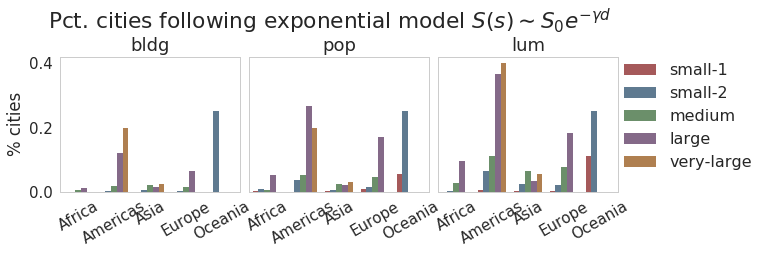

In [414]:
fig, ax = plt.subplots(1,3, figsize=(10,3), 
                       gridspec_kw={"wspace":0.05, "hspace":0.1},
                       sharex=True, sharey=True)

for a,df,src in zip(ax, [grad_bld, grad_pop, grad_lum], ['bldg', "pop", "lum"]):
    exp_model_ok = df.groupby(["region", "scale-pop"]).apply(lambda x: (x['rvalue']>0.8).sum() / float(len(x)))
    exp_model_ok = pd.DataFrame(exp_model_ok.reset_index()).rename(columns={0:"pct"})

    sns.barplot(x="region", y="pct", hue="scale-pop", palette=pop_colors,
                data=exp_model_ok, ax=a, hue_order=pop_scales)
    a.set_xlabel(""); a.set_ylabel(""); 
    a.set_xticklabels(a.get_xticklabels(), rotation=30)
    a.set_title(src)
    a.legend_.remove()
    
ax[0].set_ylabel("% cities")
ax[-1].legend(borderaxespad=0., fontsize=16, bbox_to_anchor=(1,1))
fig.subplots_adjust(top=0.75)
fig.suptitle("Pct. cities following exponential model $S(s) \sim S_0 e^{-\gamma d}$")

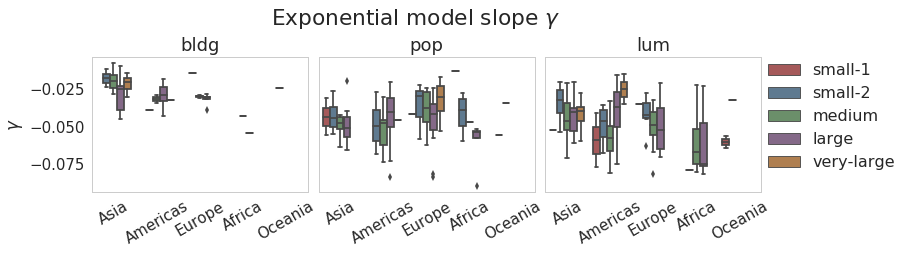

In [419]:
fig, ax = plt.subplots(1,3, figsize=(12,3), 
                       gridspec_kw={"wspace":0.05, "hspace":0.1},
                       sharex=True, sharey=True)

for a,df,src in zip(ax, [grad_bld, grad_pop, grad_lum], ['bldg', "pop", "lum"]):
    cur_df = df[df['rvalue']>0.8]
    
    sns.boxplot(x="region", y="slope", hue="scale-pop", palette=pop_colors,
                data=cur_df, ax=a, hue_order=pop_scales)
    a.set_xlabel(""); a.set_ylabel(""); 
    a.set_xticklabels(a.get_xticklabels(), rotation=30)
    a.set_title(src)
    a.legend_.remove()
    
ax[0].set_ylabel("$\gamma$")
ax[-1].legend(borderaxespad=0., fontsize=16, bbox_to_anchor=(1,1))
fig.subplots_adjust(top=0.75)
fig.suptitle("Exponential model slope $\gamma$")

Let's plot the $\gamma$s on a map to see any spatial patterns.

In [342]:
grad_pop_gdf = gpd.GeoDataFrame(pd.merge(grad_pop, cities_sel_df[['city', 'location']], 
                        left_on="city", right_on="city")).rename(columns={"location":"geometry"})
grad_lum_gdf = gpd.GeoDataFrame(pd.merge(grad_lum, cities_sel_df[['city', 'location']], 
                        left_on="city", right_on="city")).rename(columns={"location":"geometry"})
grad_bld_gdf = gpd.GeoDataFrame(pd.merge(grad_bld, cities_sel_df[['city', 'location']], 
                        left_on="city", right_on="city")).rename(columns={"location":"geometry"})


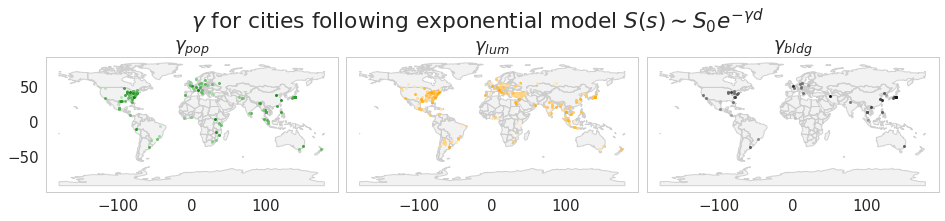

In [424]:
sns.set_context('notebook', font_scale=1.5)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['country'] = world['iso_a3'].apply(lambda x: x[:2].lower())

fig, ax = plt.subplots(1,3,gridspec_kw={"wspace":0.03, "hspace":0.13},
                           figsize=(16,3), sharex=True, sharey=True)
for c,cur_gdf,a in zip(['pop', 'lum', 'bldg'], 
                       [grad_pop_gdf[grad_pop_gdf['rvalue']>0.8], 
                        grad_lum_gdf[grad_lum_gdf['rvalue']>0.8], 
                        grad_bld_gdf[grad_bld_gdf['rvalue']>0.8]], 
                       ax.flatten()):
    world.plot(ax=a, color=[0.9,0.9,0.9,0.2], edgecolor=[0.8,0.8,0.8,0.9])
    cur_gdf.plot(ax=a, marker='.', 
                 column="slope",
                 cmap=cmap_dict[c], 
                 markersize=6, alpha=0.9)
    a.set_title("$\gamma_{%s}$"%c)
fig.subplots_adjust(top=0.75)
fig.suptitle("$\gamma$ for cities following exponential model $S(s) \sim S_0 e^{-\gamma d}$")


# Find polycentric cities 

We implement a local peak search on profiles to identify "rings" of mass accumulation. A monocentric city is one where only one peak is identified. A polycentric city is one where more than one peak is found. 

Note that because the radial profiles show average densities at a given distance, more than one secondary city centers could be present at a given distance $d$. Looking at the profile alone there's no way to determine if multiple centers exist. However, we can argue that what we're identifying are "layers" of secondary, tertiary etc. city centers (corresponding to one, two, or more "hops" from the center in a star network). 

Local peak search depends on several parameters, in particular:
* the amplitude threshold $\theta$, meaning a peak has to be at least $\theta$ larger than adjacent values in a local neighborhood
* the size of the local neighborhood $\xi$

We can do sensitivity analysis over these two parameters and study how the number of monocentric/polycentric cities changes with varying these two parameters.

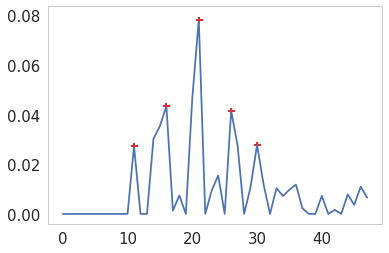

In [492]:
import peakutils

x = Xbld[240,:]
theta = 0.3
xi = 3

plt.plot(x)
plt.scatter(raw_indexes, x[raw_indexes], marker="+", color='red')

def find_peaks(X, theta=0.3, xi=3):
    f_peaks = lambda x: peakutils.indexes(x, thres=theta, min_dist=xi)
    idx_peaks = map(f_peaks, X)
    return idx_peaks    

In [463]:
peaks_bld = find_peaks(Xbld_hat)
nr_layers_bld = map(lambda x: len(x), peaks_bld)

peaks_pop = find_peaks(Xpop_hat)
nr_layers_pop = map(lambda x: len(x), peaks_pop)

peaks_lum = find_peaks(Xlum_hat)
nr_layers_lum = map(lambda x: len(x), peaks_lum)

In [470]:
layers_df = pd.concat([info_df, 
                       pd.DataFrame(np.vstack([nr_layers_bld, nr_layers_pop, nr_layers_lum]).T, 
                                    columns=["bld", "pop", "lum"])], axis=1)
layers_df.head()

,city,scale-pop,subregion,region,bld,pop,lum
0,pcs,small-1,Eastern Europe,Europe,1,1,1
1,goyang,large,Eastern Asia,Asia,4,2,3
2,mazowe,small-1,Eastern Africa,Africa,4,8,2
3,ihorombe,small-1,Eastern Africa,Africa,2,1,1
4,magelang,large,South-Eastern Asia,Asia,1,3,1


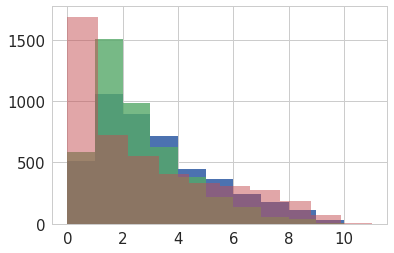

In [528]:
layers_df['bld'].hist(alpha=1)
layers_df['lum'].hist(alpha=0.8)
layers_df['pop'].hist(alpha=0.5)


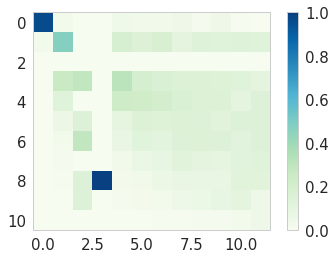

In [489]:
xtab = pd.crosstab(layers_df['bld'].astype(str), layers_df['pop'].astype(str))
xtab_norm = xtab / xtab.sum(0)
plt.imshow(xtab_norm, cmap=cm.GnBu)
plt.colorbar()

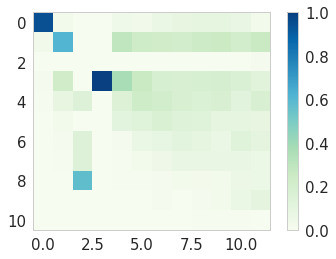

In [490]:
xtab = pd.crosstab(layers_df['lum'].astype(str), layers_df['pop'].astype(str))
xtab_norm = xtab / xtab.sum(0)
plt.imshow(xtab_norm, cmap=cm.GnBu)
plt.colorbar()

#### Sensitivity analysis wrt $\theta$ and $\xi$

In [514]:
theta_range = np.arange(0.2, 1, step=0.1)
xi_range = np.arange(2, 10)

def compute_peaks_sensitivity(X):
    bins = np.arange(0,10)
    res = {}
    for theta in theta_range:
        for xi in xi_range:
            idx_peaks = find_peaks(X, theta=theta, xi=xi)
            nr_layers = map(lambda x: len(x), idx_peaks)
            cnts, bins = np.histogram(nr_layers, bins=bins)
            res[(theta,xi)] = cnts
    return res

In [512]:
sens_bld = compute_peaks_sensitivity(Xbld_hat)

In [516]:
tmp = np.array([v[0]/float(v.sum()) for k,v in sens_bld.iteritems()]).reshape((len(theta_range), len(xi_range)))

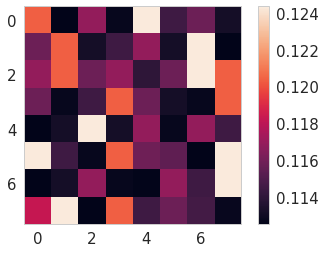

In [521]:
plt.imshow(tmp)
plt.colorbar()

In [518]:
tmp.shape

(8, 8)

# Analyze "discrepancy" between $bld$, $pop$, and $lum$ profiles

We take as reference the population distribution profile $x_{pop}$. We then define discrepancy through Earth Mover's Distance, i.e., the amount of work needed to transform $x_{bld}$ and $x_{lum}$ into $x_{pop}$.

In [533]:
from pyemd import emd, emd_with_flow
from scipy.linalg import toeplitz

In [534]:
toeplitz(range(10))

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [1, 0, 1, 2, 3, 4, 5, 6, 7, 8],
       [2, 1, 0, 1, 2, 3, 4, 5, 6, 7],
       [3, 2, 1, 0, 1, 2, 3, 4, 5, 6],
       [4, 3, 2, 1, 0, 1, 2, 3, 4, 5],
       [5, 4, 3, 2, 1, 0, 1, 2, 3, 4],
       [6, 5, 4, 3, 2, 1, 0, 1, 2, 3],
       [7, 6, 5, 4, 3, 2, 1, 0, 1, 2],
       [8, 7, 6, 5, 4, 3, 2, 1, 0, 1],
       [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]])

28.7208608777


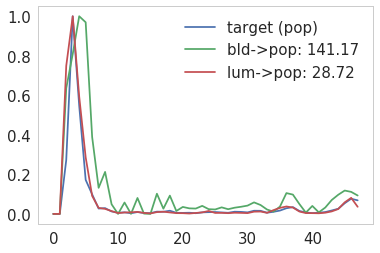

In [565]:
ref_pop = Xpop_hat[0,:]
src_bld = Xbld_hat[0,:]
src_lum = Xlum_hat[0,:]

dist_mat = toeplitz(range(len(trg)))
dist_mat = (-np.tril(dist_mat) + np.triu(dist_mat)).astype(float)

d_bld_pop, flow = emd_with_flow(src_bld, ref_pop, dist_mat)
d_lum_pop, flow = emd_with_flow(src_lum, ref_pop, dist_mat)

plt.plot(ref_pop, label="target (pop)"); 
plt.plot(src_bld, label="bld->pop: %2.2f"%d_bld_pop)
plt.plot(src_lum, label="lum->pop: %2.2f"%d_lum_pop)
plt.legend()

print dist_emd

# Cluster cities by spatial profiles

The examples above invite the following questions:
* can we identify "classes" of cities by their general macroeconomic urban form (population density, built area density, luminosity), as described by the average profiles $\hat{x}_\cdot (d)$?
* how do we model the large amount of variance around these profiles observed in the real data? In particular, can we arrive at a 'functional' model that can, in practice, emulate the real data without the need of complex modeling assumptions?

In [428]:
scales_df.head()

,city,scale-pop,subregion,region,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max,scale-bld,scale-lum,scale-bldg
0,pcs,small-1,Eastern Europe,Europe,0.079496,179109.0,1.255444,0.033861,7.258769e+05,0.337202,0.642461,2095.800000,18.472693,med,med,hi
1,goyang,large,Eastern Asia,Asia,0.349494,1033714.0,21.358686,0.195003,2.231682e+07,11.698015,0.663632,12563.666667,31.203003,med,hi,hi
2,mazowe,small-1,Eastern Africa,Africa,0.002294,161956.0,0.023511,0.003470,5.314265e+05,0.034665,0.030290,64.934282,0.155501,low,low,low
3,ihorombe,small-1,Eastern Africa,Africa,0.000716,135148.0,0.000587,0.000627,1.002725e+05,0.000502,0.057143,153.371429,0.124188,low,low,low
4,magelang,large,South-Eastern Asia,Asia,0.114572,1494199.0,0.547013,0.125196,1.009845e+07,0.868255,0.590235,3859.000000,6.042631,med,med,hi


#### Cluster profiles and plot cluster centers

In [429]:
def construct_scale_sim_matrix(scales_vec):
    N = len(scales_vec)
    S = np.zeros((N,N))
    for i in range(N):
        S[i,:] = [scales_vec[j]==scales_vec[i] for j in range(N)]
    return S

In [430]:
Sbld = construct_scale_sim_matrix(scales_df['scale-bldg'].values)
Spop = construct_scale_sim_matrix(scales_df['scale-pop'].values)
Slum = construct_scale_sim_matrix(scales_df['scale-lum'].values)


In [ ]:
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.manifold import SpectralEmbedding

def spectral_clustering(X, S, K, alpha=1):
    N, L = X.shape
    
    # compute similarity matrix
    W = euclidean_distances(X) # rbf_kernel(X) #
    W = -W * W / (float(X.shape[1])**2)
    # W = -kneighbors_graph(X, 30)
    Wt = W + (alpha * S)
    Wt = np.exp(Wt - Wt.max())

    # cluster similarity matrix
    mod = SpectralClustering(n_clusters=K,eigen_solver='arpack', 
                             affinity="precomputed")
    C = mod.fit_predict(Wt)
    lambdas = mod.eigenvalues_
    centroids = np.array([X[C==c].mean(0) for c in range(K)])

    return C, centroids, lambdas


def plot_clusters(X, C, centroids, 
                  nrow=1, text="", figsize=(6,4), top=0.75,
                  xlabels=True):
    K = len(np.unique(C))
    clust_sizes = pd.Series(C).value_counts().values
    nx = nrow
    ny = K / nx
    fig, ax = plt.subplots(nx,ny, 
                           gridspec_kw={"wspace":0.15, "hspace":0.3},
                           figsize=figsize, sharex=True, sharey=True)
    if len(ax.shape)==1:
        ax = np.expand_dims(ax, axis=0)
    for k,a in zip(range(K), ax.flatten()):
        idx = np.where(C == k)[0]
        std = X[idx,:].std(0)
        a.fill_between(xtick_labels,
           centroids[k,:]-std, 
           centroids[k,:]+std, 
           color=colormap[text], alpha=0.3)
        a.plot(xtick_labels, centroids[k,:], lw=5, color=colormap[text])
        # a.axis("off")
        a.set_title("C%d: %2.1f%%"%(k,100*float(clust_sizes[k])/clust_sizes.sum()))
        if k / ny == nx-1:
            if xlabels: a.set_xlabel("d [km]")
            a.set_xticks(xtick_labels[::6])
            a.set_xticklabels(xtick_labels[::6], rotation=30)
        if k % ny == 0:
            a.set_ylabel("log $x_{\cdot}(d)$")

    plt.suptitle("Clustering cities by $x_{%s}(d)$"%text)
    fig.subplots_adjust(top=top)

In [ ]:
C_bld, cntr_bld, lambda_bld = spectral_clustering(Xbld_hat, Sbld, 5)
city2clust_bld = dict(zip([k for k,v in cities_sel.iteritems()], C_bld))

C_pop, cntr_pop, lambda_pop = spectral_clustering(Xpop_hat, Spop, 5)
city2clust_pop = dict(zip([k for k,v in cities_sel.iteritems()], C_pop))

C_lum, cntr_lum, lambda_lum = spectral_clustering(Xlum_hat, Slum, 5)
city2clust_lum = dict(zip([k for k,v in cities_sel.iteritems()], C_lum))

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(np.arange(1,len(lambda_bld)+1), lambda_bld, label="bld", color=colormap['bldg'])
ax.scatter(np.arange(1,len(lambda_pop)+1), lambda_pop, label="pop", color=colormap['pop'])
ax.scatter(np.arange(1,len(lambda_lum)+1), lambda_lum, label="lum", color=colormap['lum'])
ax.set_title("Eigenspectrum for clustering")
ax.set_ylabel("$\lambda$")
ax.set_xlabel("# clusters")
plt.legend(loc="best")

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plot_clusters(Xbld_hat_log, C_bld, cntr_bld, text="bldg", 
              nrow=1, figsize=(14,3), top=0.75, xlabels=False)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plot_clusters(Xpop_hat_log, C_pop, cntr_pop, text="pop", 
              nrow=1, figsize=(14,3), top=0.75, xlabels=False)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plot_clusters(Xlum_hat_log, C_lum, cntr_lum, text="lum", 
              nrow=1, figsize=(14,3), top=0.75)

#### Combine luminosity & population clusters

In [ ]:
# cross-tabulate the clusters for pop, lum, bld

clust_cross = (pd.crosstab(C_bld, [C_pop,C_lum], 
                           colnames=["pop", "lum"], rownames=["bld"]).astype(float) / len(C_pop) * 100).round(1)

clust_coverage = clust_cross.values.flatten()
clust_coverage = np.sort(clust_coverage)[::-1]
clust_coverage = clust_coverage.cumsum()
K_opt = np.where(clust_coverage>55)[0][0]
print K_opt

sns.set_context("notebook", font_scale=1.5)

plt.figure(figsize=(5,3))
plt.plot(clust_coverage, lw=3)
plt.xlabel("# combined clusters (bld+pop+lum)")
plt.ylabel("% coverage")
plt.title("Selecting the number of clusters $K^*$")
plt.axhline(55, color="red")

In [ ]:
# find those clusters with at least 2% coverage

K_star = 12

pct_thresh=2.5
print "Nr. clusters with at least %d pct coverage (%2.2f): %d" % \
    (pct_thresh, 
     clust_cross[(clust_cross >= pct_thresh)].sum().sum(), 
     (clust_cross >= pct_thresh).sum().sum())

cols_pl = clust_cross.columns.values
k_bld, k_pl = np.where(clust_cross>=pct_thresh)
k_pop = np.array([cols_pl[c][0] for c in k_pl])
k_lum = np.array([cols_pl[c][1] for c in k_pl])

C_all = np.ones(len(C_bld)) * np.nan
for k,(kb,kp,kl) in enumerate(zip(k_bld, k_pop, k_lum)):
    C_all[(C_bld==kb) & (C_pop==kp) & (C_lum==kl)] = k

# assign the rest the cities based on maximal partial match

idx_na = np.where(np.isnan(C_all))[0]
idx_assgn = []
for i in idx_na:
    score = []
    for k,(kb,kp,kl) in enumerate(zip(k_bld, k_pop, k_lum)):
        score.append((C_bld[i]==kb) + (C_pop[i]==kp) + (C_lum[i]==kl))
    idx_assgn.append(np.argmax(score))
idx_assgn = np.array(idx_assgn)
C_all[idx_na] = idx_assgn

city2clust_all = dict(zip([k for k,v in cities_sel.iteritems()], C_all))

In [ ]:
sns.set_context("notebook", font_scale=1.5)

pd.Series(C_all.astype(int)).value_counts().plot(kind="bar", figsize=(5,3))
plt.title("Groups of cities by $\hat x_{%s}(d)$"%"+".join(["pop","bld","lum"]))
plt.xlabel("Spatial profile cluster")
plt.ylabel("# cities")

In [ ]:
nx = 3
ny = len(k_pop) / nx

sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(nx,ny, gridspec_kw={"wspace":0.03, "hspace":0.55},
                       figsize=(12,9), sharex=True, sharey=True)

for k,(kb,kp,kl,a) in enumerate(zip(k_bld, k_pop, k_lum, ax.flatten())):
    # plot building centroid
    idx_bld = np.where(C_bld == kb)[0]
    std = Xbld_hat_log[idx_bld,:].std(0)
    a.plot(xtick_labels, cntr_bld[kb,:], lw=3, color=colormap['bldg'], 
           label="bld: C%d"%kb)
    a.fill_between(xtick_labels,
                   cntr_bld[kb,:]-std, 
                   cntr_bld[kb,:]+std, 
                   color=colormap['bldg'], alpha=0.3)
    # plot population centroid
    idx_pop = np.where(C_pop == kp)[0]
    std = Xpop_hat_log[idx_pop,:].std(0)
    a.plot(xtick_labels, cntr_pop[kp,:], lw=3, color=colormap['pop'], 
           label="pop: C%d"%kp)
    a.fill_between(xtick_labels,
                   cntr_pop[kp,:]-std, 
                   cntr_pop[kp,:]+std, 
                   color=colormap['pop'], alpha=0.3)
    # plot luminosity centroid
    idx_lum = np.where(C_lum == kl)[0]
    std = Xlum_hat_log[idx_lum,:].std(0)
    a.plot(xtick_labels, cntr_lum[kl,:], lw=3, color=colormap['lum'], 
           label="lum: C%d"%kl)
    a.fill_between(xtick_labels,
                   cntr_lum[kl,:]-std, 
                   cntr_lum[kl,:]+std, 
                   color=colormap['lum'], alpha=0.3)
    # a.axis("off")
    a.set_title("C%d: %2.1f%%\n (C %d/%d/%d)"%(k,\
                    clust_cross.ix[kb,(kp,kl)], kb, kp, kl))
    if k / ny == nx-1:
        a.set_xlabel("d [km]")
        a.set_xticks(xtick_labels[::6])
        a.set_xticklabels(xtick_labels[::6], rotation=30)
    if k % ny == 0:
        a.set_ylabel("log $\hat x_{\cdot}(d)$")

    # a.legend(loc="best")
        
plt.suptitle("City clusters by log $\hat x_{bld,pop,lum}(d)$")
fig.subplots_adjust(top=0.85)
plt.show()


# Integrate scale-based and profile-based clusters

In [ ]:
ctab = pd.crosstab(scales_norm_df['scale'].values, 
                   C_all.astype(int)) / float(len(C_all)) * 100

sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1})
g = sns.heatmap(ctab[ctab>1], annot=True, fmt="2.0f", 
            cmap=sns.light_palette((210, 90, 60), input="husl"))

g.set_xlabel("Spatial profile ($\hat x_{\cdot}(d)$)-based clustering")
g.set_ylabel("Scale ($\hat{c}_{\cdot}$)-based clustering")

plt.suptitle("Clustering cities by scale and spatial profile")

In [ ]:
clust_tot = pd.DataFrame(np.vstack([scales_norm_df['scale'].values, 
                                    C_all.astype(int)]).T, 
                         columns=["scale", "profile"])
clust_tot.head()

In [ ]:
clust_tot_hist = clust_tot.groupby("scale")\
 .apply(lambda x: x['profile'].value_counts()/float(len(x)))
clust_tot_hist = pd.DataFrame(clust_tot_hist).reset_index()
clust_tot_hist.columns = ["scale", "profile", "share"]
clust_tot_hist['scale'] = clust_tot_hist['scale'].apply(lambda x: x.replace(",",",\n"))
clust_tot_hist.head()


In [ ]:
sns.set_context("notebook", font_scale=2.4, rc={"lines.linewidth": 1})

fig, ax = plt.subplots(figsize=(18,5))
g = sns.barplot(x="scale", y="share", hue="profile", data=clust_tot_hist, 
                  palette=my_colors);
g.legend(loc='upper left', bbox_to_anchor=(1.0, 1.2)) #, ncol=len(set(C_all)))
plt.xticks(rotation=45)
plt.title("Shares of spatial profile clusters within scale clusters")

#### Gradient spreads across profile-based clusters

In [ ]:
grad_tot = pd.DataFrame(np.vstack([grad_bld['slope'], 
                                   grad_pop['slope'], 
                                   grad_lum['slope']]).T,
                        columns=["bld", "pop", "lum"])
grad_tot = pd.concat([info_df, grad_tot, clust_tot], axis=1)
grad_tot.head()

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig, ax = plt.subplots(figsize=(9,3))

tmp = grad_tot[['bld', 'pop', 'lum', 'profile']]
tmp = pd.melt(tmp, id_vars=["profile"])

sns.boxplot(x="profile", y='value', hue="variable", ax=ax, showfliers=False,\
            data=tmp[tmp['value']>0], palette=colormap.values()[1:])
plt.legend(loc="best")
plt.xlabel("Spatial profile cluster")
plt.ylabel("$\gamma_{\cdot}$")
plt.title("Average spatial gradient $\gamma$ across city clusters")

# Illustrate example cities in each class

#### Read in all image source paths

In [ ]:
import glob

files = glob.glob(dataroot + "urban_areas_over_10kpop_log/*.tif")
files_df = []
for f in files:
    s = f.split("/")
    fname = s[-1]
    cls = fname.split("_")[3]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])
files_df['city'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
files_df['source'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[0])

files_df = files_df[files_df['city'].isin(cities_sel.keys())]

sources = files_df.groupby("city").apply(\
                    lambda x: (x[['city', 'country', 'population', 'class']].iloc[0].to_dict(), 
                               dict(zip(x['source'], x['filename']))))
sources = dict(zip(sources.index.tolist(), sources.values.tolist()))

print len(sources)

#### Make example canvass to plot for each 

In [ ]:
from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None):
    img = imread(f)
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    img = (img - img.min()) / float((img.max() - img.min()))
    return img

def concat_sources(src):
    i0 = read_img(src[1]['POP'])
    i1 = read_img(src[1]['NLI'])
    i2 = read_img(src[1]['SAR'])
    mask = i0==0
    img= np.zeros(i1.shape+(3,))
    img[:,:,0] = i0; img[:,:,1] = i1; img[:,:,2] = i2;
    img[mask] = 0
    return img

In [ ]:
def make_canvass(image_paths, labels, nExamples=10, thumbSize = (64,64,3), pad_pix=2, title="example"):
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.ones(((thumbSize[0]+pad_pix)*nClusters, nExamples*(thumbSize[1]+pad_pix), 3))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = concat_sources(image_paths[idx[j]])
            img = resize(img, thumbSize, preserve_range=True)
            canvas[i*(thumbSize[0]+pad_pix):(i*pad_pix + (i+1)*thumbSize[0]), 
                   j*(thumbSize[1]+pad_pix):(j*pad_pix + (j+1)*thumbSize[1])] = img
    return canvas

In [ ]:
canvas = make_canvass(sources.values(), 
                      [city2clust_all[x] for x in sources.keys()])

In [ ]:
nClusters = len(np.unique(C_all))

# plot examples of each class
fig,ax = plt.subplots(1, figsize=(12,10))
plt.tight_layout()
print canvas.shape
ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
ax.set_title("Classes of cities: examples", fontsize=18)
ax.set_ylabel("-- examples --", fontsize=16)
ax.set_xlabel("-- classes --", fontsize=16)
# Turn off tick labels
ax.set_xticks([64 * (0.5 + x*1.03) + 2 for x in range(nClusters)])
ax.set_xticklabels(["C%d"%x for x in range(nClusters)], fontsize=16, rotation=90)
ax.set_yticklabels([])
# plt.axis("off")
plt.show()

#### Geographical distribution of clusters

In [ ]:
cities_gdf = gpd.GeoDataFrame(cities_sel_df)
#cities_gdf['geometry'] = cities_gdf['geometry'].apply(lambda s: shapely.wkt.loads(s))
cities_gdf['cluster'] = cities_gdf['City'].apply(lambda x: int(city2clust_all[x]) if x in city2clust_all else np.nan)
# cities_gdf.dropna(inplace=True)

In [ ]:
sns.set_context('notebook', font_scale=1.5)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(3,4,gridspec_kw={"wspace":0.03, "hspace":0.03},
                           figsize=(16,7), sharex=True, sharey=True)
for c,a in zip(range(len(set(C_all))), ax.flatten()):
    world.plot(ax=a, color=[0.9,0.9,0.9,0.2], edgecolor=[0.8,0.8,0.8,0.9])
    cur_gdf = cities_gdf[cities_gdf['cluster']==c].sort_values("Population", ascending=False)
    cur_gdf.plot(ax=a, marker='.', color=my_colors[c], markersize=6, alpha=1.0)
    print "C%d:"%c, cur_gdf.head(3)['City'].values.tolist()
    a.annotate("C%d"%c, xy=(-140, -45))
plt.suptitle("Communities of Metropolitan Regions: Detail View")
fig.subplots_adjust(top=0.93)

In [ ]:
sns.set_context('notebook', font_scale=2)

ax = cities_gdf.plot(figsize=(20,6), marker='*', color='black', markersize=3)
for c,col in zip(range(len(set(C_all))), my_colors):
    cities_gdf[cities_gdf['cluster']==c].plot(ax=ax, marker='.', color=col, markersize=6, alpha=0.9)
plt.title("Communities of Metropolitan Regions")
plt.xlabel("longitude")
plt.ylabel("latitude")

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.835, 0.1, 0.03, 0.8])

# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: "C%d"%val)

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=matplotlib.colors.Normalize(0,8))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
sm.set_clim(-0.5, len(set(C_all))-0.5)

# We must be sure to specify the ticks matching our target names
cb = fig.colorbar(sm, ticks=range(len(set(C_all))), format=formatter, cax=cax);
cb.set_ticks(range(len(set(C_all))))

# Relate clusters to macroeconomic data on cities

In this section, we analyze the relationship between several macroeconomic indicators measured at the level of cities or countries to the classes of urban form that the city belongs to. We use a discrete-choice modeling approach, where the dependent variable is the city class, and the independent variables (covariates) are the macroeconomic indicators. 

#### Integrate data at city level

In [ ]:
# load data on cities

attributes_df = pd.read_csv(dataroot + "cities_macroeconomic_data.csv")
attributes_df['city'] = attributes_df['city'].apply(\
                                        lambda x: re.sub(r' \([^)]*\)', '', x))
attributes_df = attributes_df.fillna(attributes_df.mean())
attributes_df.set_index("city", inplace=True)

with gzip.open(dataroot + "cities_macroeconomic_variables.pickle.gz", "r") as f:
    vars_dict = pickle.load(f)

print attributes_df.shape

attributes_df.head()

In [ ]:
clust_tot.head()

In [ ]:
# format cluster info: city level

clust_df = pd.DataFrame(np.vstack([C_pop, C_bld, C_lum, C_all, ]).T, \
                        columns=["pop", "bld", "lum", "all"], 
                        index=[v['city'] for k,v in cities_sel.iteritems()])
clust_df.index = [s.split("(")[0][:-1] for s in clust_df.index]
clust_df['scale'] = clust_tot['scale'].values
clust_df.head()

In [ ]:
city_data_df = attributes_df.join(clust_df)
city_data_df.dropna(inplace=True)
city_train_cols = attributes_df.columns.values.tolist() 
city_weights = np.ones(len(city_data_df))

#### Integrate data at country level

This kind of classification with "soft labels" is not supported in standard machine learning or statistics packages like `scikit-learn` or `statsmodels`. However, this is equivalent to a standard logistic regression, with weights on each sample corresponding to the soft label (between 0 and 1).

In [ ]:
# load data on countries

country_df = pd.read_csv(dataroot + "country_macro_indicators.csv")
country_df.set_index("code", inplace=True)
country_df.drop('CountryName', axis=1, inplace=True)
country_df = pd.get_dummies(country_df)
country_df.head()

In [ ]:
clust_df.head()

In [ ]:
# format cluster info: country level

clust_country_df = clust_df.reset_index().rename(columns={"index":"city"})
clust_country_df['country'] = clust_country_df['city'].apply(lambda x: x.split(",")[1][1:])
clust_country_df = clust_country_df[['country', "all", "scale"]]
clust_country_df = pd.get_dummies(clust_country_df, columns=["scale"], prefix_sep="")
# clust_country_df = pd.get_dummies(clust_country_df, columns=["all"])
# clust_country_df.columns = ['country'] + [i for i in range(clust_country_df.shape[1]-1)]
# clust_country_df = clust_country_df.groupby("country").apply(lambda x:  x.iloc[:,1:].sum(0)/float(len(x)))
# clust_country_df = pd.melt(clust_country_df.reset_index(), id_vars="country",
#                            var_name="cluster", value_name="weight")
# clust_country_df = clust_country_df[clust_country_df['weight']>0]
clust_country_df.rename(columns={"all":"cluster"}, inplace=True)
clust_country_df.set_index("country", inplace=True)
clust_country_df.head()

In [ ]:
country_data_df = country_df.join(clust_country_df)
country_data_df.dropna(inplace=True)
country_train_cols = list(set(country_data_df.columns.values.tolist()) - set(['cluster']))

# country_weights = country_data_df['weight'].values
# country_data_df.drop("weight", axis=1, inplace=True)
country_weights = np.ones(len(country_data_df))

#### Perform analysis

Since we have so few data points (150) and relatively many features (40), let's first find the most important ones via a random forest classifier.

In [ ]:
data_df = country_data_df
X = country_data_df[country_train_cols].values
weights = country_weights
train_cols = country_train_cols

# X = city_data_df[city_train_cols].values

X = (X - X.mean(0)) / (X.std(0) + 1e-6)
X = np.hstack([X, np.ones((len(X),1))])
train_cols += ['intercept']

print X.shape, weights.shape

In [ ]:
import statsmodels.api as st
from sklearn.ensemble import RandomForestClassifier

def mnl_analysis(resp_col="pop", reg=0, top=10):
    y = data_df[resp_col].astype(str).values
    
    # select a few important variables
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X, y, weights)
    feat_imp = pd.Series(clf.feature_importances_)
    feat_imp.index = train_cols
    feat_imp.sort_values(ascending=False, inplace=True)
    feat_imp.head(top)[::-1].plot(kind='barh')
    imp_cols = feat_imp.head(top)[::-1].index.values.tolist() + ['intercept']
    print "top %d features: "% top, imp_cols
    
    mnl = st.MNLogit(y, X[:,[train_cols.index(c) for c in imp_cols]])
    mnl_fit = mnl.fit_regularized(alpha=reg)
    mnl_stats = mnl_fit.summary()
    
    # extract statistically-significant variables
    
    param_df = pd.DataFrame(mnl_fit.params, index=imp_cols )
    pvals_df = pd.DataFrame(mnl_fit.pvalues, index=imp_cols )
    idx_ok = (pvals_df<=0.05).sum(1)>0
    signif_vars_df = param_df[idx_ok]
    signif_vars_df[pvals_df>0.05] = np.nan
    signif_vars_df.index = [vars_dict[x] if x in vars_dict else x\
                            for x in signif_vars_df.index]
    signif_vars_df.columns = ["C%d"%(c+1) for c in signif_vars_df.columns]
    # signif_vars_df = signif_vars_df.fillna(0)
    
    return signif_vars_df #signif_vars_df.ix[signif_vars_df.abs().sum(1) > 0]

In [ ]:
signif_vars = mnl_analysis("cluster", reg=0.00)
signif_vars.index = [x.replace("scale","").replace(",",",\n") for x in signif_vars.index]

In [ ]:
sns.set_context('notebook', font_scale=1.5)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(signif_vars, cmap="RdBu_r", center=0, ax=ax, 
            annot=True, fmt="2.1f", )

plt.title("Significant country-level effects")
plt.xlabel("Spatial profile clusters")

#### Save data to file

In [ ]:
sav_df = pd.concat([info_df, clust_df.reset_index().drop("index",1)], axis=1)
sav_df['country'] = sav_df['city'].apply(lambda x: x.split(",")[1].split('(')[0][1:])
sav_df.to_csv(dataroot + "cities_clusters.csv")

In [ ]:
sav_df.head()

In [ ]:
pd.DataFrame(cntr_pop).to_csv(dataroot + "cluster_centers_pop.csv")
pd.DataFrame(cntr_lum).to_csv(dataroot + "cluster_centers_lum.csv")
pd.DataFrame(cntr_bld).to_csv(dataroot + "cluster_centers_bld.csv")

# SCRATCH

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering
from numpy.random import random_sample
from math import sqrt, log

# returns series of random values sampled between min and max values of passed col
def get_rand_data(col):
	rng = col.max() - col.min()
	return pd.Series(random_sample(len(col))*rng + col.min())

def iter_kmeans(df, n_clusters, num_iters=10):
    rng =  range(1, num_iters + 1)
    vals = pd.Series(index=rng)
    for i in rng:
        k = KMeans(n_clusters=n_clusters, n_init=10)
        k.fit(df)
        # print "Ref k: %s" % k.get_params()['n_clusters']
        vals[i] = k.inertia_
    return vals

def gap_statistic(df, max_k=10):
    gaps = pd.Series(index = range(1, max_k + 1))
    for k in range(1, max_k + 1):
        print k,
        km_act = KMeans(n_clusters=k, n_init=10)
        km_act.fit(df)

        # get ref dataset
        ref = df.apply(get_rand_data)
        ref_inertia = iter_kmeans(ref, n_clusters=k).mean()

        gap = log(ref_inertia - km_act.inertia_)

        # print "Ref: %s   Act: %s  Gap: %s" % ( ref_inertia, km_act.inertia_, gap)
        gaps[k] = gap
    print "Done!"

    return gaps

In [ ]:
# gap statistic analysis to find optimum number of clusters

# population profiles
gaps_pop = gap_statistic(pd.DataFrame(Xpop_hat_log), max_k=25)
K_pop = np.argmax(gaps_pop)

# luminosity profiles
gaps_lum = gap_statistic(pd.DataFrame(Xlum_hat_log), max_k=25)
K_lum = np.argmax(gaps_lum)

# building density profiles
gaps_bld = gap_statistic(pd.DataFrame(Xbld_hat_log), max_k=25)
K_bld = np.argmax(gaps_bld)


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(gaps_pop/gaps_pop.max(), lw=3, label="pop", color=colormap['pop'])
plt.plot(gaps_lum/gaps_lum.max(), lw=3, label="lum", color=colormap['lum'])
plt.plot(gaps_bld/gaps_bld.max(), lw=3, label="bld", color=colormap['bldg'])
plt.title("Optimum # clusters $K^*$")
plt.xlabel("# clusters K")
plt.ylabel("gap statistic")
plt.legend(loc="best")
plt.show()
